**Importing of libraries + mounting the GTZAN dataset**

In [ ]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import pandas
import matplotlib.pyplot as plt
import warnings
#import category_encoders as cat_encoder
from sklearn.preprocessing import LabelBinarizer
warnings.filterwarnings('ignore')
from keras.layers import LSTM, GRU, RNN, Bidirectional, Dense, Dropout, Input, Flatten
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import OneHotEncoder
import keras
from keras import layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.layers import RNN
from keras import backend
import librosa #needed to extract MFCCs
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle/
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification --unzip

Mounted at /content/drive
/content/drive/MyDrive/Kaggle
404 - Not Found


**Reading targetted file**

Contains the features of the audio clips (not the spectrograms)

---



In [ ]:
#Dataset: features_3_sec.csv
df = pandas.read_csv('/content/drive/MyDrive/Kaggle/Data/features_3_sec.csv')

#Dataset: features_30_sec.csv
#df = pandas.read_csv('/content/drive/MyDrive/Kaggle/Data/features_30_sec.csv')



**Graph Plotting Function**

In [ ]:
def plot(training_results, validation_results, results_type, model_name):
    fig = plt.figure(figsize=[8, 6])

    plt.plot(training_results, 'r', linewidth=3.0)
    plt.plot(validation_results, 'b', linewidth=3.0)
    plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(results_type, fontsize=16)
    plt.title(results_type + ' of ' + model_name, fontsize=16)

def plot_accuracy(history, model_name):
    plot(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', model_name)


def plot_loss(history, model_name):
    plot(history.history['loss'], history.history['val_loss'], 'Loss', model_name)

**Extraction of the MFCCs from GTZAN**

There are two forms of the MFCCs in the dataset, there are the MFCCs variance, and the mean. After testing on both, the MFFCs mean got better accuracy results.

In [ ]:
extracted_MFCCs = []
for index, row in tqdm(df.iterrows()):
    genres = row['label']
    mfcc = []
#there are 20 different MFCCs for every audio file, so we're going to extract thhe 20 MFFCs and the corresponding label to every 20)
  #  for i in range(0,20):
    for i in range(1,21):
      #mfcc.append(row['mfcc'+ str(i)+'_var'])
      mfcc.append(row['mfcc'+ str(i)+'_mean'])
    extracted_MFCCs.append([mfcc, genres])
print(extracted_MFCCs[0][0])
print(extracted_MFCCs[0][1])
print(extracted_MFCCs[1][0])
print(extracted_MFCCs[1][1])
print(extracted_MFCCs[2][0])
print(extracted_MFCCs[2][1])

9990it [00:01, 6683.11it/s]

[-118.62791442871094, 125.08362579345705, -23.443723678588867, 41.32148361206055, -5.976108074188232, 20.115140914916992, -16.04541015625, 17.85519790649414, -14.633434295654297, 10.270526885986328, -9.70827865600586, 10.18387508392334, -4.681614398956299, 8.417439460754395, -7.233476638793945, -2.8536033630371094, -3.2412803173065186, 0.7222089767456055, -5.05033540725708, -0.2430267930030822]
blues
[-125.59070587158205, 122.42122650146484, -20.718019485473636, 50.12838745117188, -11.33330249786377, 21.385400772094727, -15.960796356201172, 19.454103469848636, -12.465917587280272, 17.898168563842773, -11.73255443572998, 8.145000457763672, -7.717750549316406, 8.397150039672852, -8.300493240356445, 4.074709415435791, -6.055294036865234, 0.1590154767036438, -2.8376989364624023, 5.784063339233398]
blues
[-132.4419403076172, 115.08517456054688, -14.81166648864746, 50.18929290771485, -0.6808194518089294, 24.650375366210938, -13.506104469299316, 15.643385887145996, -13.216636657714844, 10.406

**Reorganizing extracted data into table**

I will then use the table to split it into two arrays, one for the MFCCs_mean and one for the corresponding genre classes

In [ ]:
extracted_features_df = pandas.DataFrame(extracted_MFCCs, columns=['extracted features','genre classification'])
x = np.array(extracted_features_df['extracted features'].tolist())
print(x.shape)
g = np.array(extracted_features_df['genre classification'].tolist())
#display(g)

(9990, 20)


**One-hot encoder for text input**

Used for the music genre classes since they're text inputs

In [ ]:
genre_classes = {'Genre': g}

df = pandas.DataFrame(genre_classes)
one_hot_encoder = LabelBinarizer()
one_hot_encoder_output = one_hot_encoder.fit_transform( df['Genre'])
enc_y = pandas.DataFrame(one_hot_encoder_output, columns = one_hot_encoder.classes_)
display(enc_y)


# df = pandas.DataFrame(columns=['blues',	'classical', 'country',	'disco', 'hiphop', 'jazz', 'metal',	'pop',	'reggae',	'rock'])

# indx = 0

# for i in target:
#   if i == 'blue':
#     df.insert(indx, , "0")

# display(df)

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9985,0,0,0,0,0,0,0,0,0,1
9986,0,0,0,0,0,0,0,0,0,1
9987,0,0,0,0,0,0,0,0,0,1
9988,0,0,0,0,0,0,0,0,0,1


**Splitting data into training and test data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, enc_y, test_size=0.2, random_state=8)
#Dataset: features_3_sec.csv

#test_size=0.3
#np.array(X_train).reshape(6993, 1, 20)

#test_size=0.2
np.array(X_train).reshape(7992, 1, 20)



#Dataset: features_30_sec.csv
#np.array(X_train).reshape(700, 1, 20)
#X_test.shape

array([[[-126.98323059,   90.9648819 ,   -5.45112562, ...,
           -3.86198545,   -4.79632282,   -5.04565763]],

       [[ -62.78665924,   80.59348297,  -20.63264084, ...,
            4.69052172,   -5.66636086,    3.71627951]],

       [[-177.11141968,  112.3611145 ,  -33.39751434, ...,
           -4.80053091,   -1.71011198,   -0.6724537 ]],

       ...,

       [[ -70.14759827,  103.24803162,   -0.79092902, ...,
           -3.52521825,   -2.95958495,   -3.03603959]],

       [[ -25.47847557,   60.18863678,   11.28849506, ...,
            0.84218341,   -1.2466675 ,    2.00404644]],

       [[-159.20288086,  113.4284668 ,  -15.85126781, ...,
           -4.93219328,   -2.99037933,   -2.43536973]]])

In [ ]:
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = backend.dot(inputs, self.kernel)
        output = h + backend.dot(prev_output, self.recurrent_kernel)
        return output, [output]

# Let's use this cell in a RNN layer:


cells = [MinimalRNNCell(32), MinimalRNNCell(64), MinimalRNNCell(64), MinimalRNNCell(64)]

**Building the RNN model**

In [ ]:
model = Sequential()
model.add(Input(shape = (1,20)))
model.add(Bidirectional(LSTM(256, return_sequences = True,  dropout = 0.2)))
#model.add(Bidirectional(GRU(256, return_sequences = True,  dropout = 0.2)))
#model.add(RNN(cells))

model.add(LSTM(64))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))
#adam = tf.keras.optimizers.Adam(lr = 0.001),
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics=['accuracy'])
    #optimizer = 'SGD',
    #optimizer = 'RMSProp',
    #loss = 'poisson',

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 1, 512)           567296    
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 64)                147712    
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1024)              66560     
                                                                 
 dense_5 (Dense)             (None, 10)                10250     
                                                                 
Total params: 791,818
Trainable params: 791,818
Non-trainable params: 0
________________________________________________

**Testing my model**

In [ ]:
#Dataset: features_3_sec.csv



#For test_size = 0.2
history = model.fit(np.array(X_train).reshape(7992, 1, 20),np.array(y_train),epochs=100, batch_size = 25, validation_data = (np.array(X_test).reshape(1998,1,20),np.array(y_test)))
preds = model.evaluate(np.array(X_test).reshape(1998,1,20),np.array(y_test), batch_size=25)

#For test_size = 0.3
# history = model.fit(np.array(X_train).reshape(6993, 1, 20),np.array(y_train),epochs=100, batch_size = 30, validation_data = (np.array(X_test).reshape(2997,1,20),np.array(y_test)))
# preds = model.evaluate(np.array(X_test).reshape(2997,1,20),np.array(y_test), batch_size=30)

#Dataset: features_30_sec.csv
#history = model.fit(np.array(X_train).reshape(700, 1, 20),np.array(y_train),epochs=100, batch_size = 30, validation_data = (np.array(X_test).reshape(300,1,20),np.array(y_test)))
#preds = model.evaluate(np.array(X_test).reshape(300,1,20),np.array(y_test), batch_size=30)

Epoch 1/100
320/320 [==============================] - 13s 22ms/step - loss: 1.6803 - accuracy: 0.3916 - val_loss: 1.3855 - val_accuracy: 0.5030
Epoch 2/100
320/320 [==============================] - 6s 17ms/step - loss: 1.4683 - accuracy: 0.4677 - val_loss: 1.3263 - val_accuracy: 0.5110
Epoch 3/100
320/320 [==============================] - 6s 18ms/step - loss: 1.3926 - accuracy: 0.4946 - val_loss: 1.2482 - val_accuracy: 0.5551
Epoch 4/100
320/320 [==============================] - 6s 18ms/step - loss: 1.3462 - accuracy: 0.5150 - val_loss: 1.2793 - val_accuracy: 0.5460
Epoch 5/100
320/320 [==============================] - 5s 17ms/step - loss: 1.2832 - accuracy: 0.5385 - val_loss: 1.1060 - val_accuracy: 0.6126
Epoch 6/100
320/320 [==============================] - 6s 18ms/step - loss: 1.2561 - accuracy: 0.5468 - val_loss: 1.1907 - val_accuracy: 0.5696
Epoch 7/100
320/320 [==============================] - 6s 18ms/step - loss: 1.2212 - accuracy: 0.5621 - val_loss: 1.1293 - val_accuracy

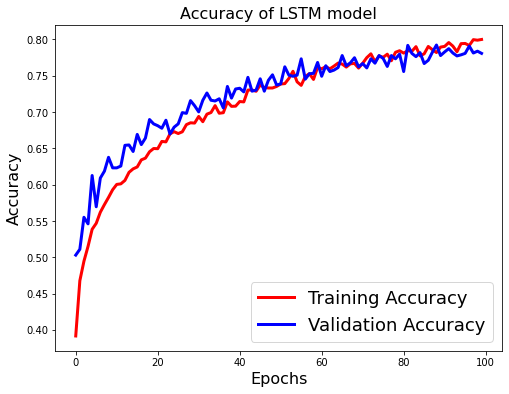

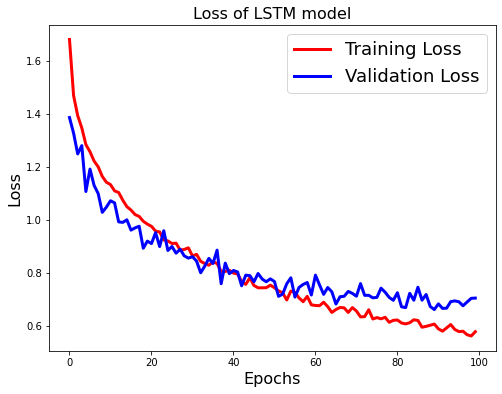

In [ ]:
plot_accuracy(history, "LSTM model")
plot_loss(history, "LSTM model")

plt.show()

In [ ]:
print ("Validation Loss = " + str(preds[0]))
print ("Validation Accuracy = " + str(preds[1]))

Validation Loss = 0.7036150097846985
Validation Accuracy = 0.7807807922363281
